In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import sdf
import tqdm
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["font.size"] = 14

## Constants

In [2]:
c = 3*1e8
e = 1.6*1e-19
m=9.1*1e-31
epsilon = 8.85418782e-12


## Simulation Parameters

In [3]:
lambda0 = 1e-6
tau=lambda0/c
las_time = 20*tau
omega0 = 2*np.pi*c/lambda0
Er = m * omega0 * c / e
nx = 16000
t_end =40*tau
dt_snapshot = 0.08e-15
x_min = -20*lambda0
x_max = 20*lambda0
factor =4
nc = epsilon*m*omega0**2/e**2
n0 = factor*nc

## Envelope
The envelope of the incident laser field varies according to

$$
    P(t)=
    \begin{cases}
         & \sin^2(\pi t/T) \text{ for } 0 \leq t \le T \\
         & 0         \;      \text{ otherwise }
    \end{cases}
$$


In [4]:
t_max = las_time
samples = 1000

In [5]:
def sine_sq(t):
    if t<t_max:
        a = np.sin(2*np.pi*t/tau)
        return a*np.sin(np.pi*t/las_time)**2
    else:
        return 0

In [42]:
t = np.linspace(0, t_max, samples)

In [7]:
pulse = np.array([sine_sq(t_i) for t_i in t])

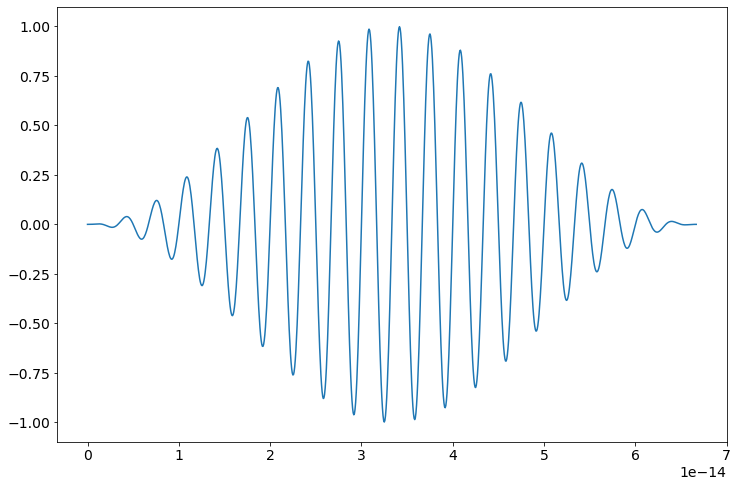

In [8]:
plt.plot(t, pulse)

FFT of the envelope

In [9]:
# Want to resolve frequecy

f0 = omega0/(2*np.pi)
f0,omega0

(300000000000000.0, 1884955592153876.0)

Want to resolve frequecy 

omega0 = 1884955592153876.0

f0 = omega0/(2*np.pi) 

f0 = 300000000000000.0

min sample frequency = 2*f0 = 600000000000000.0

dt_max = 1/2*f0 = 1.6666666666666667e-15

our dt must be less than dt_max while fourier transformation for resolution of frequency omega0
dt = 6.666666666666667e-17



In [10]:
dt = t_max/samples
print('dt: ',dt)
f_max = 1/dt
f = np.linspace(-f_max/2, f_max/2, samples)
omega_fft = 2*np.pi*f

dt:  6.666666666666667e-17


(0.0, 10.0)

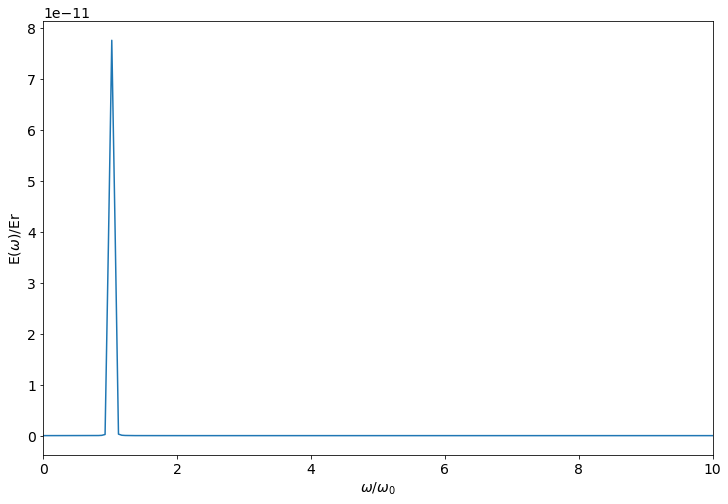

In [11]:
sine_sq_fft = np.fft.fftshift(np.fft.fft(pulse))
plt.plot(omega_fft/omega0, np.abs(sine_sq_fft)/Er)
plt.xlabel(r'$\omega/\omega_0$')
plt.ylabel('E($\omega$)/Er')
plt.xlim(0, 10)

## Simulation

The maximum time step for resolution of the frequency must be 

In [12]:
omega_to_resolve = 20*omega0
f_to_resolve = omega_to_resolve/(2*np.pi)
min_sampling_freq = 2*f_to_resolve
dt_max_to_resolve = 1/(min_sampling_freq)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15: .3f} femto seconds")

The maximum time step for resolution is  0.083 femto seconds


In [13]:
files = glob.glob('tau_20/*.sdf')
files.sort()
samples = len(files)
print(f"Number of files: {samples}")
print('dt_snapshot: ',dt_snapshot)

Number of files: 1669
dt_snapshot:  8e-17


f_resolve is the frequency we want to resolve, and we take f_samples = 2*f_resolve and corresponding dt_max=dt_snapshot = 1/f_samples

In [14]:
f_samples = 1/dt_snapshot
f_resolve= f_samples/2
omega_resolve= 2*np.pi*f_resolve
omega_resolve/omega0

20.833333333333332

In [15]:
# data at time  = 100*dt_snapshot=8e-15 
all_data=sdf.read(files[100])
all_data.Electric_Field_Ey.data.shape

(16000,)

In [16]:
all_data.Electric_Field_Ey.data[0]

129214492701.50955

In [17]:
den = all_data.Derived_Number_Density_Electron.data

## Density Plot

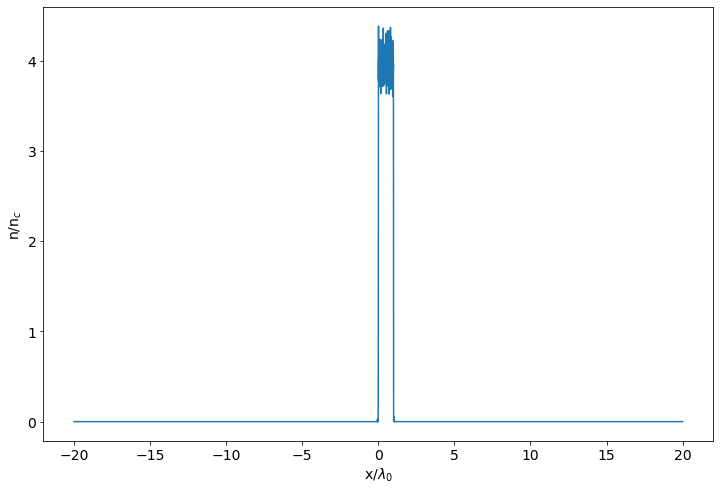

In [18]:
x = np.linspace(x_min, x_max, nx)
t = np.linspace(0, t_end, len(files))
plt.plot(x/lambda0,den/nc)
plt.xlabel('x/$\lambda_0$')
plt.ylabel('n/n$_c$');

In [19]:
arr = np.zeros((len(files),nx))
Ey_0=[]
Ey_4000=[]
Ey_8000=[]
i=0
for f in tqdm.tqdm(files, desc='Reading files...'):
    E=sdf.read(f).Electric_Field_Ey.data
    Ey_0.append(E[0])
    Ey_4000.append(E[4000])
    Ey_8000.append(E[8000])
    arr[i]=sdf.read(files[i]).Derived_Number_Density_Electron.data
    i+=1


Reading files...: 100%|██████████| 1669/1669 [05:14<00:00,  5.30it/s]


In [28]:
arr.shape

(1669, 16000)

In [29]:
EXTENT = [-20, 20, 40, 0]

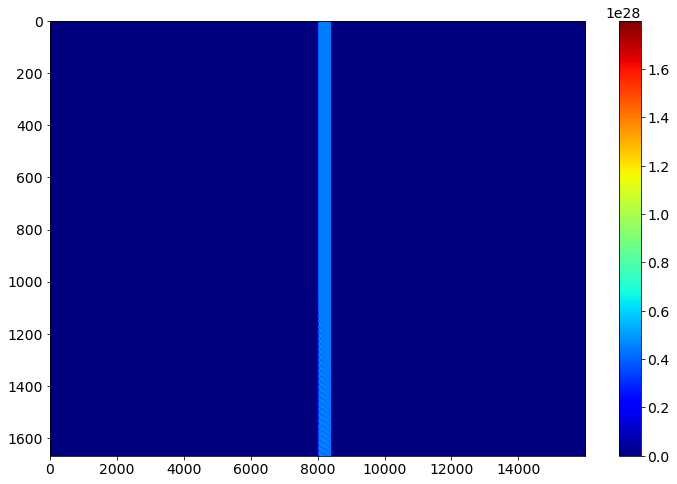

In [30]:
plt.imshow(arr[:, :],  aspect="auto", cmap="jet")
plt.colorbar()

In [33]:
(1500*dt_snapshot)/tau

36.00000000000001

In [34]:
EXTENT = [ 7900,8100,36,31]

Text(0, 0.5, 't/tau')

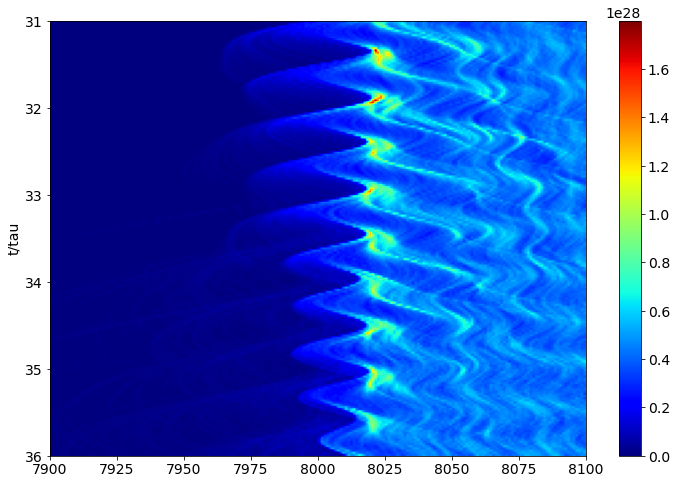

In [36]:
plt.imshow(arr[1300:1500, 7900:8100],extent=EXTENT ,aspect="auto", cmap="jet")
plt.colorbar();
plt.ylabel("t/tau")

## Electric Field

In [44]:
Ey_0 = np.array(Ey_0)
Ey_4000 = np.array(Ey_4000)
Ey_8000 = np.array(Ey_8000)


Text(0.5, 1.0, 'Ey at zeroth Node')

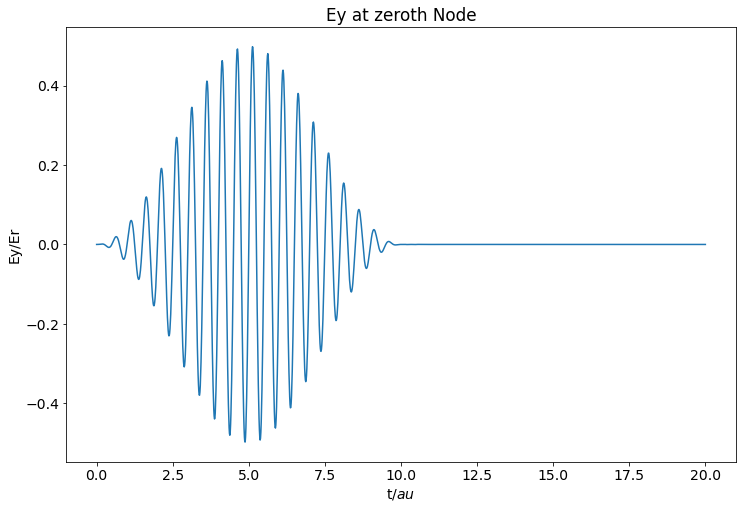

In [45]:
plt.plot(t/tau, Ey_0/Er)
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.title('Ey at zeroth Node')

Text(0.5, 1.0, 'Ey at 4000th Node')

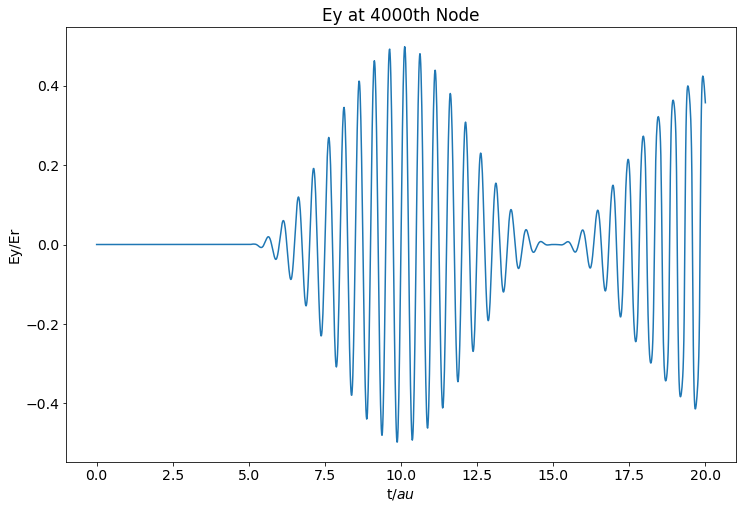

In [46]:
plt.plot(t/tau, Ey_4000/Er)
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.title('Ey at 4000th Node')

Text(0.5, 1.0, 'Ey at 8000th Node')

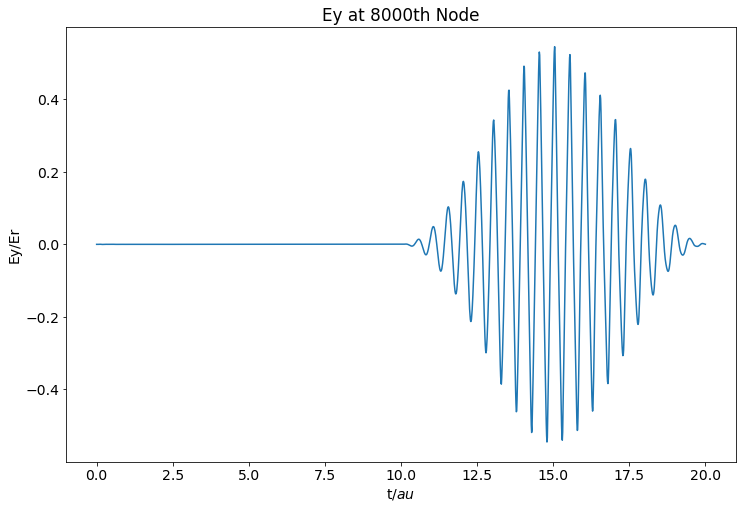

In [47]:
plt.plot(t/tau, Ey_8000/Er)
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.title('Ey at 8000th Node')

## FFT

In [48]:
f_max = 1/dt_snapshot
samples = len(files)
f = np.linspace(-f_max/2, f_max/2, samples)
omega_fft = 2*np.pi*f


In [49]:
Ey_0_fft = np.fft.fft(Ey_0)
Ey_0_fft = np.fft.fftshift(Ey_0_fft)

In [50]:
Ey_0_fft = np.fft.fft(Ey_0)
Ey_0_fft = np.fft.fftshift(Ey_0_fft)

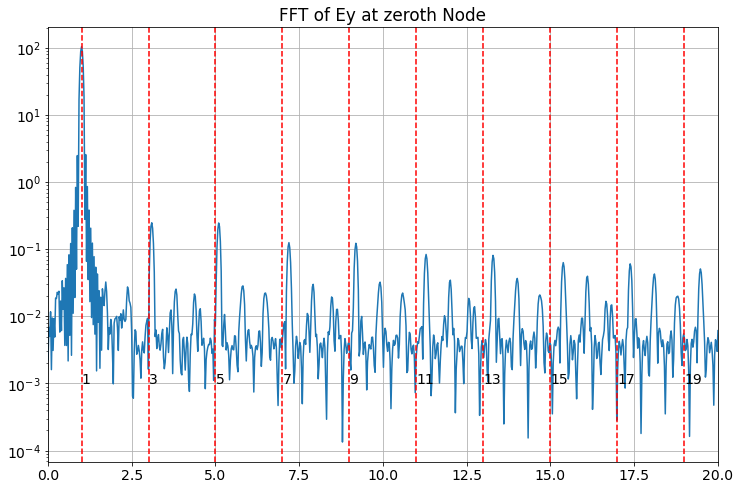

<Figure size 3600x2400 with 0 Axes>

In [51]:
Ey_0_fft = np.fft.fft(Ey_0)
Ey_0_fft = np.fft.fftshift(Ey_0_fft)
plt.plot(omega_fft/omega0, np.abs(Ey_0_fft)/Er)
plt.title('FFT of Ey at zeroth Node')
plt.xlim(0,20)
plt.yscale("log")
plt.grid()
for i in range(1,20,2):
    plt.axvline(i, color='r', linestyle='--')
    plt.annotate(f"{i}",  (i, 1e-3),color='black')
plt.figure(dpi=300);


In [52]:
omega_fft.shape

(1669,)

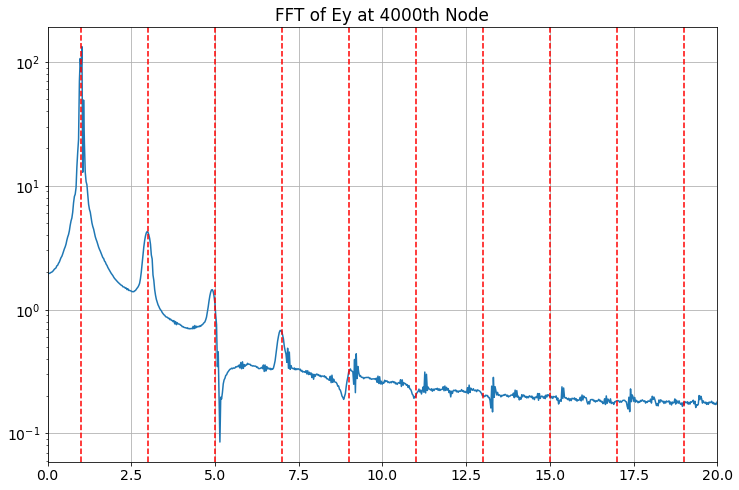

In [53]:
Ey_4000_fft = np.fft.fft(Ey_4000)
Ey_4000_fft = np.fft.fftshift(Ey_4000_fft)
# plt.figure(dpi=300)
plt.plot(omega_fft/omega0, np.abs(Ey_4000_fft)/Er)
plt.xlim(0,20)
plt.title('FFT of Ey at 4000th Node')
plt.yscale("log")
plt.grid()
for i in range(1,20,2):
    plt.axvline(i, color='r', linestyle='--')
    plt.annotate(f"{i}",  (i, 1e-3),color='black')
plt.show()

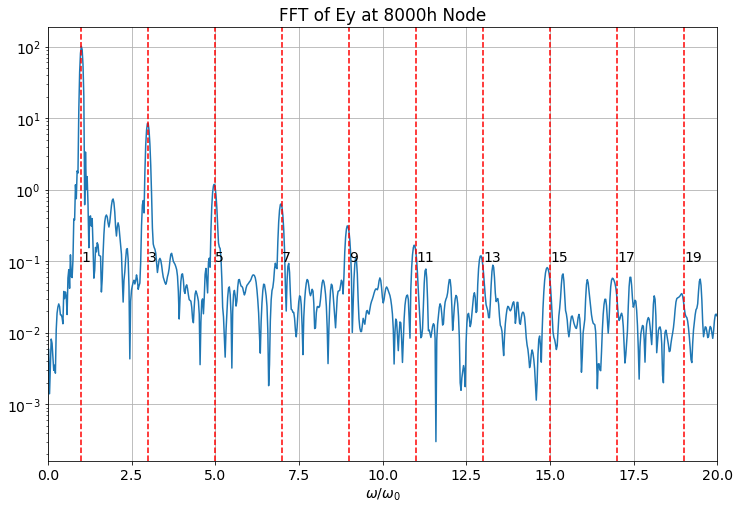

In [54]:
Ey_8000_fft = np.fft.fft(Ey_8000)
Ey_8000_fft = np.fft.fftshift(Ey_8000_fft)
plt.plot(omega_fft/omega0, np.abs(Ey_8000_fft)/Er)
plt.xlim(0,20)
plt.title('FFT of Ey at 8000h Node')
plt.yscale("log")
plt.xlabel('$\omega/\omega_0$')
plt.grid()
for i in range(1,20,2):
    plt.axvline(i, color='r', linestyle='--')
    plt.annotate(f"{i}",  (i, 1e-1),color='black')
plt.show()